<a href="https://colab.research.google.com/github/abir-tcheir/testGit/blob/main/EfficientNetSmallDataVF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***DataSet of binary class***

# Import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
import os
import zipfile
import datetime
from collections import Counter
 
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
 
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
 
from keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam, schedules
 
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

# Data visualization

Normal chest x-ray


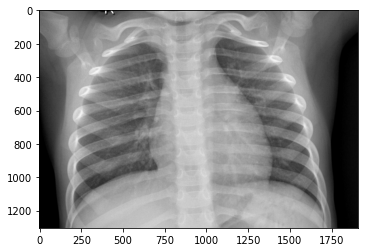

COVID chest x-ray


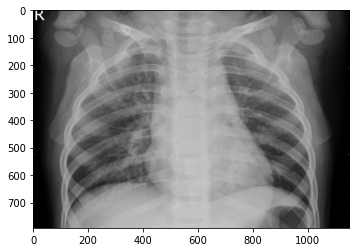

' \nprint("Viral Pneumonia chest x-ray")\nim = PIL.Image.open(os.path.join(img_path,\'Viral Pneumonia\',pneumonia_imgs[0]))\nplt.imshow(im,cmap="gray")\nplt.show()\n'

In [ ]:
img_path = '/content/drive/My Drive/datasetCOVIDB/'
 
covid_imgs = os.listdir(img_path+'/COVID')
normal_imgs = os.listdir(img_path+'/Non-COVID')

#show images

print("Normal chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Non-COVID',normal_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()
 
print("COVID chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'COVID',covid_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()


# Image pre-processing and train-test split

In [ ]:
list_files = []
for dir in os.listdir(img_path):
  aux_dir = os.path.join(img_path,dir)
  
  if os.path.isdir(aux_dir):
    for img in os.listdir(aux_dir):
      list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

,id,label
count,9545,9545
unique,9545,2
top,Non-COVID/NORMAL2-IM-0798-0001.jpeg,Non-COVID
freq,1,5500


In [ ]:
def frequency_plot(df):
  freq_abs = Counter(df.label);
  freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
  freq_a.columns = ['Label','absolute frequency']
  return freq_a
frequency_plot(df)

,Label,absolute frequency
0,Non-COVID,5500
1,COVID,4045


In [ ]:
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['label']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['label'][train_index], df['label'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf
 
#divide train/val/test in 80/10/10
traindf,testdf = split_dataset(df,test_size = 0.25)
valdf,testdf= split_dataset(testdf,test_size = 0.50)
 
traindf.id = img_path + traindf.id
valdf.id = img_path + valdf.id
testdf.id = img_path + testdf.id

In [ ]:
frequency_plot(traindf)

,Label,absolute frequency
0,Non-COVID,4125
1,COVID,3033


In [ ]:
frequency_plot(valdf)

,Label,absolute frequency
0,Non-COVID,687
1,COVID,506


In [ ]:
frequency_plot(testdf)

,Label,absolute frequency
0,Non-COVID,688
1,COVID,506


# Image Data Generator

In [ ]:
BATCH_SIZE = 50
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [ ]:
 
"""
train_datagen = ImageDataGenerator(          
    rotation_range = 40,
    width_shift_range = 0.2,
  height_shift_range=0.2,
  shear_range = 0.2,
  zoom_range = 0.1,
  fill_mode = 'nearest',
)
"""
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
 
 
print("Creating train generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="datasetCOVIDB",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="binary",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)
 
 
val_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="datasetCOVIDB",
    x_col="id",
    y_col="label",
    color_mode="rgb",
    seed=5,
    shuffle = False,
    batch_size=30,
    class_mode="binary",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)
 
print("\nCreating val generator...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valdf,
    directory="datasetCOVIDB",
    x_col="id",
    y_col="label",
    batch_size=5,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="binary",
    
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Creating train generator...


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 7152 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1192 validated image filenames belonging to 2 classes.

Creating val generator...
Found 1193 validated image filenames belonging to 2 classes.


# Classifier Model
## Importing EfficientnetB0 model

In [ ]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-kfdd7z6n
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-kfdd7z6n
     |████████████████████████████████| 50 kB 2.9 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=5e2d51c43bb871252c6c2eb31e87f95216c38e1a2a6c4e99c2033f53f2a842b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-m7h20bks/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [ ]:
import efficientnet.tfkeras as enet
base_model =enet.EfficientNetB0(include_top=False, input_shape=(224,224,3), pooling='avg', weights="imagenet",classes=2)
#Freeze base convolutional layers
base_model.trainable = False
base_model.summary()

16818176/16804768 [==============================] - 0s 0us/step
Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
___________________

# Addition of fully connected layers

In [ ]:
#from keras.layers import AveragePooling2D, BatchNormalization
from keras.regularizers import l1_l2
from keras.regularizers import l2
from keras.regularizers import l1
from keras.layers import Dropout
from keras.models import Model 
from keras.layers import Flatten 
from keras.layers import BatchNormalization

x = base_model.output
x = Flatten()(x)

x = BatchNormalization()(x)
 
x = Dense(1024)(x)
x = Activation("relu")(x)
x = Dropout(0.3)(x)

x = BatchNormalization()(x)
 
x = Dense(1024)(x)
x = Activation("relu")(x)
x = Dropout(0.3)(x)

# Output layer
predictions = Dense(1, activation="sigmoid")(x)
 
model= Model(inputs = base_model.input, outputs = predictions)


# Model visualization



In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

In [ ]:
 EPOCHS =21
LEARNING_RATE = 1e-5
DECAY= LEARNING_RATE/EPOCHS
model.compile(
     loss='binary_crossentropy',
     optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE),
     metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)
 
history = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    #callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/21
50/50 [==============================] - 70s 1s/step - loss: 0.5167 - recall: 0.7692 - precision: 0.7692 - acc: 0.7692 - val_loss: 0.3013 - val_recall: 0.8960 - val_precision: 0.8960 - val_acc: 0.8960
Epoch 2/21
50/50 [==============================] - 58s 1s/step - loss: 0.2877 - recall: 0.8872 - precision: 0.8872 - acc: 0.8872 - val_loss: 0.2478 - val_recall: 0.9200 - val_precision: 0.9200 - val_acc: 0.9200
Epoch 3/21
50/50 [==============================] - 57s 1s/step - loss: 0.2059 - recall: 0.9264 - precision: 0.9264 - acc: 0.9264 - val_loss: 0.2351 - val_recall: 0.9360 - val_precision: 0.9360 - val_acc: 0.9360
Epoch 4/21
50/50 [==============================] - 57s 1s/step - loss: 0.1831 - recall: 0.9380 - precision: 0.9380 - acc: 0.9380 - val_loss: 0.1151 - val_recall: 0.9760 - val_precision: 0.9760 - val_acc: 0.9760
Epoch 5/21
50/50 [==============================] - 55s 1s/step - loss: 0.1580 - recall: 0.9449 - precision: 0.9449 - acc: 0.9449 - val_loss: 0.1842 - v

'\nacc=history.history[\'acc\'], label=\'train data\'\nval_acc=history.history[\'val_acc\']\nloss=history.history[\'loss\']\nval_loss=history.history[\'val_loss\']\n \nplt.plot( acc)\nplt.plot( val_acc)\n#plt.title(\'Training and validation accuracy\')\nplt.title(\'PretrainedResnet50 Train/Test Loss\')\nplt.ylabel(\'Loss\')\nplt.xlabel(\'Number of Epochs\')\nplt.legend(loc="upper left")\n \nplt.figure()\n'

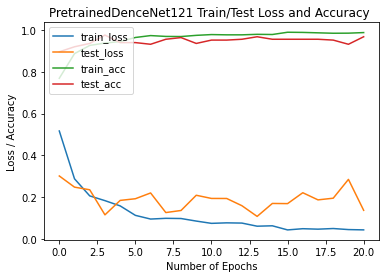

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
 
N = EPOCHS
#plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="test_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="test_acc")
plt.title("PretrainedDenceNet121 Train/Test Loss and Accuracy ")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="upper left")
 

# Confusion Matrix  & Pres  & Recall   & F1-Score


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[474  32]
 [ 18 668]]
classification_Report
              precision    recall  f1-score   support

       COVID       0.96      0.94      0.95       506
      NORMAL       0.95      0.97      0.96       686

    accuracy                           0.96      1192
   macro avg       0.96      0.96      0.96      1192
weighted avg       0.96      0.96      0.96      1192



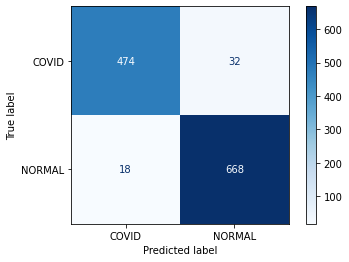

In [ ]:
 
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
 
target_names = ['COVID', 'NORMAL']
label_names = [0,1]
 
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred ,  axis = 1)
 
cm = confusion_matrix(test_generator.classes, y_pred, labels = label_names)
 
 
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
 
print('classification_Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
 
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format = 'g')
plt.show()

# Grad Cam

In [ ]:
#grad_cam

def proc_img(img_path):
  '''process the image'''
  # `img` is a PIL image of size 224x224
  img = image.load_img(img_path, target_size=(224, 224))

  # `x` is a float32 Numpy array of shape (224, 224, 3)
  x_img = image.img_to_array(img)

  # We add a dimension to transform our array into a matrix
  # of size (1, 224, 224, 3)
  x_img = np.expand_dims(x_img, axis=0)

  # Finally we preprocess the batch
  # (this does channel-wise color normalization)
  x_img = preprocess_input(x_img)
  return x_img

In [ ]:
tf.compat.v1.disable_eager_execution()
"""To visualize which parts of the image are the most important for the each  
label for the classifier, let’s set up the Grad-CAM process."""

blck = 'top_conv'  
def xray_CAM(x_img, blck, label): 
  "gives the CAM heatmap"

  # the prediction vector
  pred_output = model.output[:, label]

  # The is the output feature map of the `top_conv` layer,
  # the last convolutional layer in EfficientNet
  last_conv_layer = model.get_layer(blck)

  # This is the gradient of the image's class with regard to
  # the output feature map of `top_conv`
  grads = K.gradients(pred_output, last_conv_layer.output)[0]

  # This is a vector of shape (1024,), where each entry
  # is the mean intensity of the gradient over a specific feature map channel
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # This function allows us to access the values of the quantities we just defined:
  # `pooled_grads` and the output feature map of `top_conv`,
  # given a sample image
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  # These are the values of these two quantities, as Numpy arrays,
  # given our sample image of two elephants
  pooled_grads_value, conv_layer_output_value = iterate([x_img])

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the elephant class
  for i in range(1280): # we have 1280 features in our last conv layer
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(conv_layer_output_value, axis=-1) # create a heatmap
  heatmap = np.maximum(heatmap, 0)  # remove negative values
  heatmap /= np.max(heatmap)  # normalize
  
  return heatmap

In [ ]:
def show_on_xray(img_path, heatmap):
  # We use cv2 to load the original image
  img = cv2.imread(img_path)

  # We resize the heatmap to have the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  # We convert the heatmap to RGB
  heatmap = np.uint8(255 * heatmap)

  # We apply the heatmap to the original image
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  # 0.4 here is a heatmap intensity factor
  superimposed_img = heatmap * 0.4 + img

  ## Save the image to disk
  cv2.imwrite('./covid19-test.jpg', superimposed_img)
  img_samp = cv2.imread('./covid19-test.jpg')  #OpenCV has BGR order
  img_samp = cv2.cvtColor(img_samp, cv2.COLOR_BGR2RGB)  #matplotlib has RGB order
  
  plt.imshow(img_samp)

In [ ]:
from keras.preprocessing import image

import keras
from keras import backend as K 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
#from keras.layers.normalization import BatchNormalization
#from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
#from keras.optimizers import Adam, Adamax
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

# The local path to our target image
img_path = '/content/drive/My Drive/Dataset2/COVID/covid19-test.jpg'

x_img = proc_img(img_path)

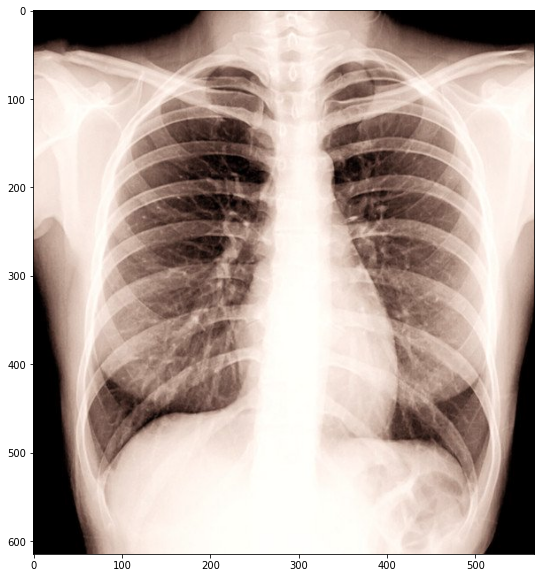

In [ ]:
import cv2
plt.rcParams['figure.figsize'] = (12.0, 10.0)
img_samp = cv2.imread(img_path)
plt.imshow(img_samp);

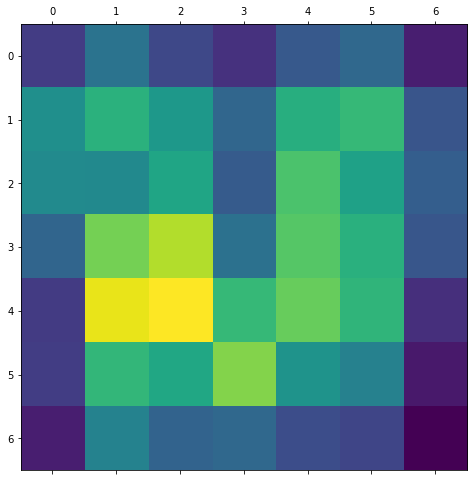

In [ ]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
heatmap = xray_CAM(x_img, blck, 1)
plt.matshow(heatmap)
plt.show()

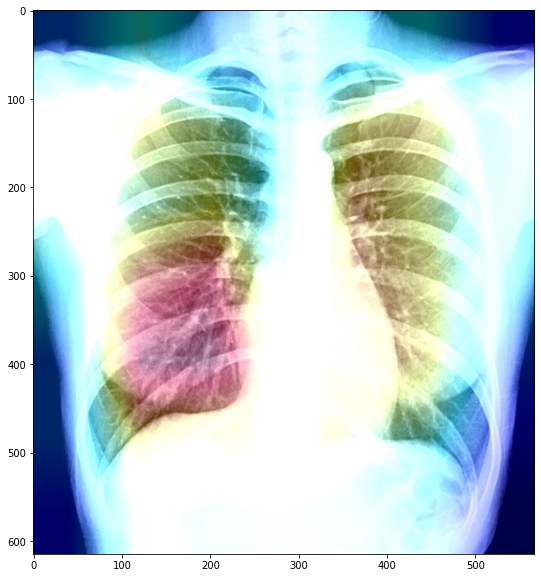

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
show_on_xray(img_path, heatmap)

In [ ]:
img_path = '/content/drive/My Drive/datasetCOVIDB/COVID/covid19-test.jpg'
x_img = proc_img(img_path)


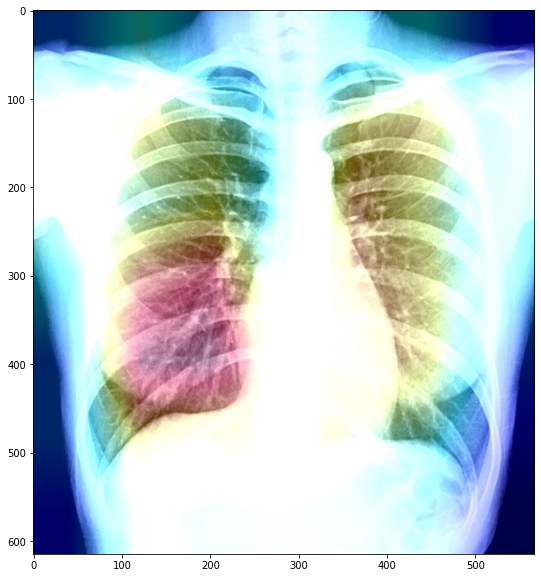

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
show_on_xray(img_path, heatmap)

# Lime

In [ ]:
!pip install lime


In [ ]:
import lime
from lime import lime_image
from skimage.io import imread
from skimage.segmentation import mark_boundaries

In [ ]:

img_path = '/content/drive/My Drive/datasetCOVIDB/COVID/covid19-test.jpg'

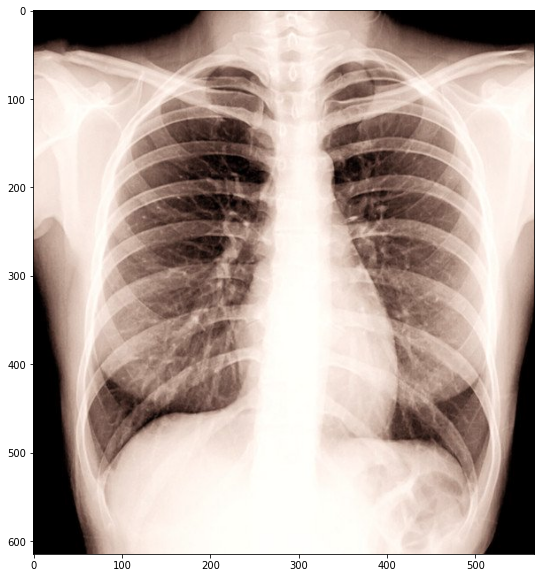

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
img_samp_n = cv2.imread(img_path)
plt.imshow(img_samp_n);
plt.show();

In [ ]:
p_img = proc_img(img_path)
#prnt_out(p_img)

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:

explanation = explainer.explain_instance(p_img[0], model.predict, 
                                         top_labels=2, hide_color=0,
                                         num_samples=1000,
                                         distance_metric='cosine')

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


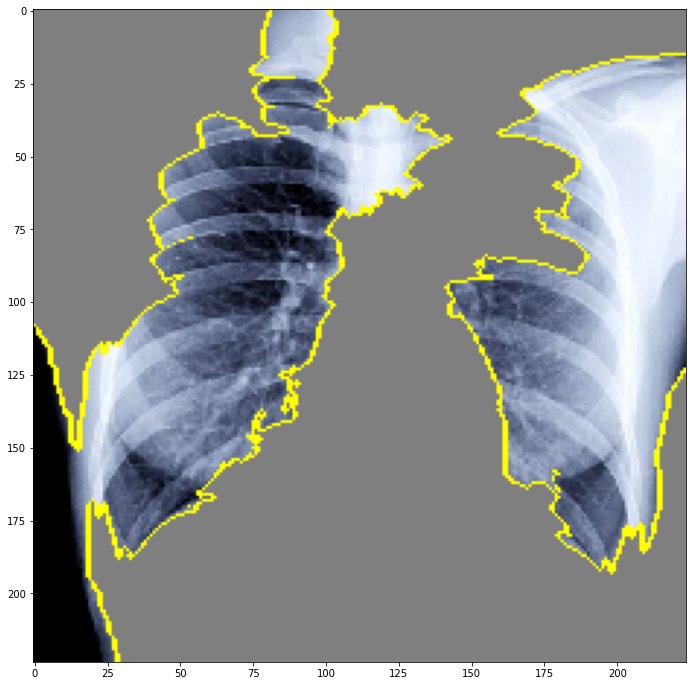

In [ ]:
temp, mask = explanation.get_image_and_mask(label=1, positive_only=True, 
                                            num_features=15, hide_rest=True,
                                            min_weight=0.0000004)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.imshow(mark_boundaries(tempp, mask));

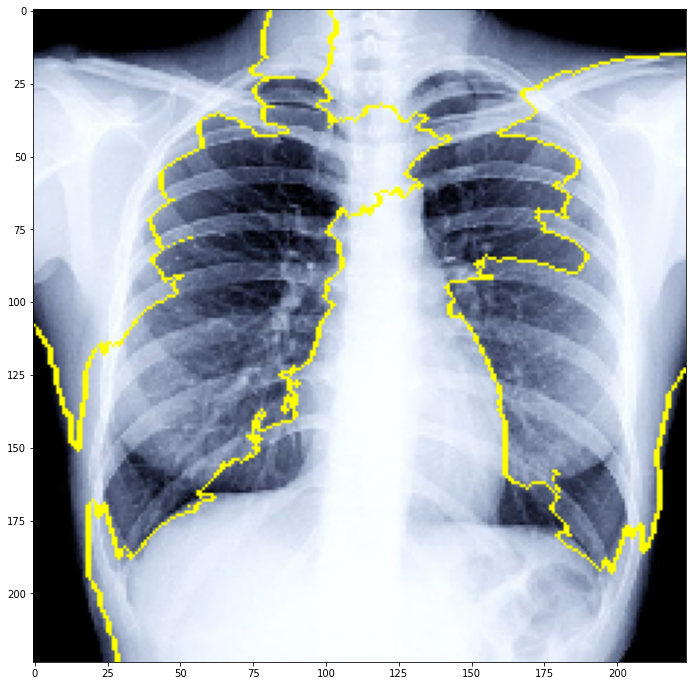

In [ ]:
temp, mask = explanation.get_image_and_mask(label=1, positive_only=True, 
                                            num_features=15, hide_rest=False,
                                            min_weight=0.0000004)

tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));

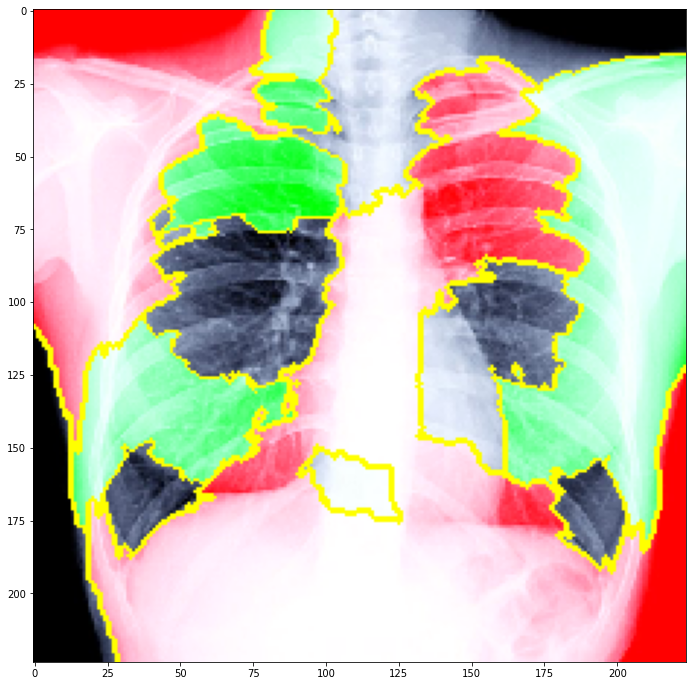

In [ ]:
temp, mask = explanation.get_image_and_mask(label=1, positive_only=False, 
                                            num_features=15, hide_rest=False, 
                                            min_weight=0.0000004)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));

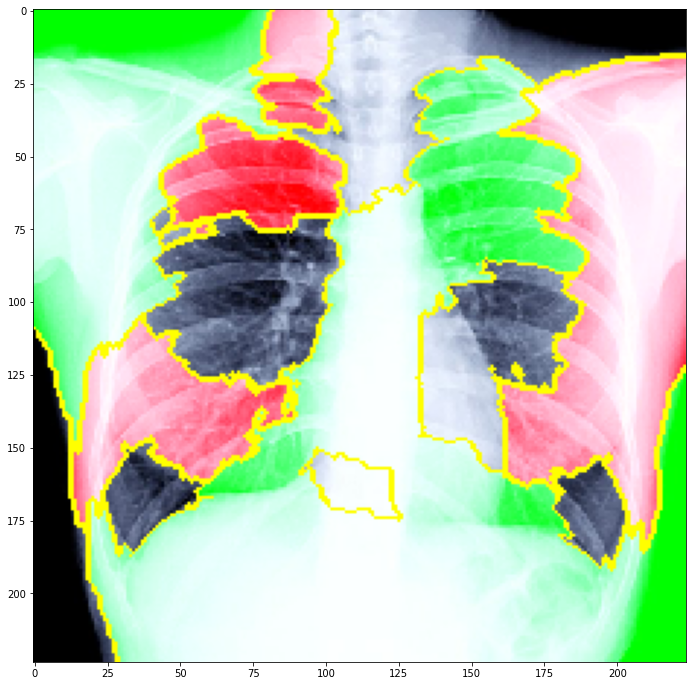

In [ ]:
temp, mask = explanation.get_image_and_mask(label=0, positive_only=False, 
                                            num_features=15, hide_rest=False, 
                                            min_weight=0.0005)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));